<a href="https://colab.research.google.com/github/nastaranmarzban/BGAT-and-GAT-Jupyter-notebook/blob/main/BGAT_gene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount to gdrive to read data, adjacency matrix, p_link and labels.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Install pandas to read csv files from gdrive. Install torch and numpy which are packages that are needed durind coding.

In [ ]:
!pip install pandas
import pandas as pd
import torch
import numpy as np

# Load data which are processed in preprocessing_gene.ipynb file.

In [ ]:
path = F"/gdrive/MyDrive/gene_better/gene.pt"
Data = torch.load(path)
Data

{'x': tensor([[ 6.4493,  6.0844,  7.3716,  ...,  8.6918, 10.8691, 11.2004],
         [12.4170, 11.6782, 13.3738,  ...,  9.0700, 10.2089, 10.4571],
         [ 8.1833,  6.4246, 10.5602,  ...,  7.3575,  6.6114,  7.7576],
         ...,
         [ 6.6002,  7.4879,  8.0421,  ...,  9.6510,  8.9851,  9.4696],
         [ 6.6107,  7.4934,  8.0498,  ...,  9.6591,  8.9828,  9.4788],
         [ 6.6001,  7.4911,  8.0561,  ...,  9.6553,  8.9820,  9.4658]]),
 'edge_index': tensor([[ 0,  0,  0,  ..., 89, 89, 89],
         [ 8, 10, 57,  ..., 85, 86, 87]]),
 'y': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 'train_mask': tensor([False, False, False, False,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True

# Gather some statistics about the graph.

In [ ]:
print(f'Number of nodes: {Data["x"].size(0)}')
print(f'Number of features: {Data["x"].size(1)}')
print(f'Number of classes: {torch.numel(torch.unique(Data["y"],sorted=True))}')
print(f'Number of edges: {Data["edge_index"].size(1)}')
print(f'Average node degree: {Data["edge_index"].size(1) / Data["x"].size(0):.2f}')
print(f'Number of training nodes: {Data["train_mask"].sum()}')
print(f'Number of testing nodes: {Data["test_mask"].sum()}')
print(f'Training node label rate: {int(Data["train_mask"].sum()) /  Data["x"].size(0):.2f}')

Number of nodes: 90
Number of features: 60
Number of classes: 3
Number of edges: 1650
Average node degree: 18.33
Number of training nodes: 78
Number of testing nodes: 6
Training node label rate: 0.87


# Read p_link from gdrive to use it as the attention.

In [ ]:
path = F"/gdrive/MyDrive/gene_better/p_links_gene.pt"
p_link = torch.load(path)
print(p_link.size())
print(p_link.dtype)
print(p_link.type())

torch.Size([90, 90])
torch.float32
torch.FloatTensor


# Install torch_geometic.

In [ ]:
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 18.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Developing our own model (making our own message passing layers).

# BGATConv
$$ X^\prime _i = \sum_{j \in N(i)\cup i} \alpha_{ij}\Theta X_j$$
In which $\alpha$s are computed via BDgraph(p_link) and $\Theta$ is learnable parameter.

In [ ]:
from torch_geometric.nn import MessagePassing
import torch_geometric.nn
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops

# Creating message passing network.

In [ ]:
class BGATConv(MessagePassing):
    def __init__(
        self,
        in_channels,
        out_channels,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim = 0, **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(Data["edge_index"], num_nodes = Data["x"].size(0))
        x = self.lin(x)
        atten = p_link
        return self.propagate(edge_index, x=x, atten = atten)

    def message(self, x_j, atten, edge_index_i, edge_index_j):
        return atten[edge_index_i, edge_index_j].reshape(-1,1) * x_j

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels, self.out_channels)

# Make GNN layers with our own model, BGAT. We use three BGAT conv.

In [ ]:
class Myconv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(2)
        self.conv1 = BGATConv(in_channels = 60, out_channels = 50)
        self.conv2 =  BGATConv(50, 40)
        self.conv3 =  BGATConv(40,3)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.tanh(h)
        h = self.conv2(h, edge_index)
        h = F.tanh(h)
        h = self.conv3(h, edge_index)# Final GNN embedding space.
        #h = F.log_softmax(h)
        return h

model = Myconv()
print(model)
print(model.forward(Data["x"], Data["edge_index"]))

Myconv(
  (conv1): BGATConv(60, 50)
  (conv2): BGATConv(50, 40)
  (conv3): BGATConv(40, 3)
)
tensor([[ 1.4922,  1.5166, -1.6515],
        [ 1.9044,  1.6444, -1.8727],
        [ 2.1815,  1.7250, -1.9218],
        [ 1.5220,  1.5679, -1.7114],
        [ 2.0908,  2.0201, -2.2341],
        [ 1.4520,  1.2701, -1.4096],
        [ 0.6078,  0.7121, -0.7961],
        [ 2.6852,  2.4455, -2.8045],
        [ 2.7774,  2.8129, -3.0090],
        [ 4.0700,  3.7438, -4.3121],
        [ 3.2382,  2.8873, -3.2800],
        [ 2.5982,  2.5244, -2.8736],
        [ 1.6162,  1.3235, -1.4535],
        [ 2.5006,  2.0557, -2.2244],
        [ 1.9941,  1.7188, -1.9233],
        [ 3.4362,  3.5050, -3.7774],
        [ 3.6530,  3.7594, -4.0105],
        [ 3.7242,  3.6521, -3.9556],
        [ 2.4622,  2.3954, -2.6249],
        [ 3.8446,  3.9358, -4.3069],
        [ 1.5139,  1.6826, -1.8428],
        [ 2.1299,  1.8178, -2.0525],
        [ 1.9001,  1.3478, -1.6110],
        [ 2.0278,  1.9502, -2.1932],
        [ 2.2703,  

# We take a look at the node embeddings produced by our GNN (before training).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize(h):
    z = TSNE(n_components = 2, random_state = 0).fit_transform(h.detach().numpy())
    plt.figure(figsize = (6,4),  dpi = 120)
    sns.scatterplot(x = z[:, 0], y = z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",3)).set(title = "Gene expression data T-SNE projection before training (BGAT)")

Embedding shape: [90, 3]


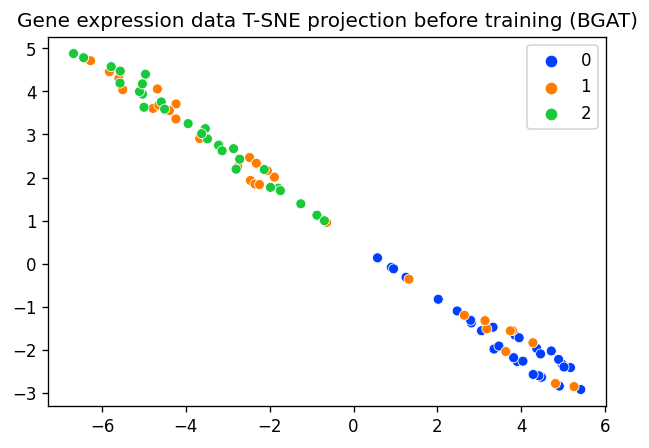

In [ ]:
model = Myconv()
h = model(Data["x"], Data["edge_index"])

print(f'Embedding shape: {list(h.shape)}')
visualize(h)

# Start training the model.

In [ ]:
model = Myconv()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(),  lr = 0.0001, weight_decay = 0.05)  # Define optimizer, an object for updating parameters
#loss = loss + weight decay parameter * L2 norm of the weights, 1) To prevent overfitting 2) To keep the weights small and avoid exploding gradient

def train(Data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(Data["x"], Data["edge_index"])
    train_loss = criterion(out[Data["train_mask"]], Data["y"][Data["train_mask"]])  # Compute the loss solely based on the training nodes.
    train_loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return train_loss


def val(Data):
      model.eval()
      with torch.no_grad():
        out = model(Data["x"], Data["edge_index"])
        val_loss = criterion(out[Data["val_mask"]], Data["y"][Data["val_mask"]])
        #pred = out.argmax(dim=1)
        #test_correct = pred[Data["val_mask"]] == Data["y"][Data["val_mask"]]  # Check against ground-truth labels.
        #test_acc = int(test_correct.sum()) / int(Data["val_mask"].sum())  # Derive ratio of correct predictions.
        return val_loss

In [ ]:
train_loss_ = []
val_loss_ = []

for epoch in range(1,79):

  epoch_train_loss = []
  epoch_val_loss = []
  train_loss = train(Data)
  val_loss = val(Data)






  epoch_train_loss.append(train_loss.item())
  epoch_val_loss.append(val_loss.item())






  val_loss_.append(sum(epoch_val_loss)/len(epoch_val_loss))
  train_loss_.append(sum(epoch_train_loss)/len(epoch_train_loss))
  print(epoch,'Train Loss: %.3f | val Loss: %.3f'%( train_loss,val_loss))

1 Train Loss: 4.792 | val Loss: 4.515
2 Train Loss: 4.353 | val Loss: 4.147
3 Train Loss: 3.985 | val Loss: 3.803
4 Train Loss: 3.642 | val Loss: 3.474
5 Train Loss: 3.316 | val Loss: 3.161
6 Train Loss: 3.005 | val Loss: 2.863
7 Train Loss: 2.709 | val Loss: 2.578
8 Train Loss: 2.426 | val Loss: 2.307
9 Train Loss: 2.154 | val Loss: 2.047
10 Train Loss: 1.894 | val Loss: 1.800
11 Train Loss: 1.646 | val Loss: 1.567
12 Train Loss: 1.414 | val Loss: 1.356
13 Train Loss: 1.210 | val Loss: 1.184
14 Train Loss: 1.060 | val Loss: 1.077
15 Train Loss: 1.006 | val Loss: 1.054
16 Train Loss: 1.067 | val Loss: 1.081
17 Train Loss: 1.169 | val Loss: 1.105
18 Train Loss: 1.228 | val Loss: 1.113
19 Train Loss: 1.233 | val Loss: 1.109
20 Train Loss: 1.205 | val Loss: 1.106
21 Train Loss: 1.167 | val Loss: 1.108
22 Train Loss: 1.137 | val Loss: 1.117
23 Train Loss: 1.119 | val Loss: 1.127
24 Train Loss: 1.109 | val Loss: 1.133
25 Train Loss: 1.097 | val Loss: 1.130
26 Train Loss: 1.080 | val Loss: 1

# Visualize train loss and val loss.

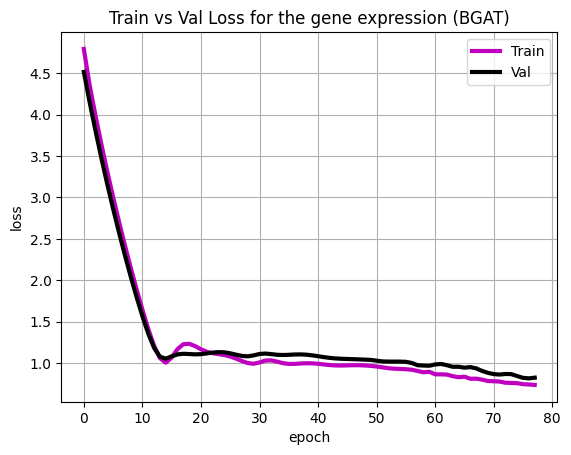

In [ ]:
plt.plot(train_loss_, "m", linewidth = 3)
plt.plot(val_loss_, "k", linewidth = 3)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Val'])
plt.title('Train vs Val Loss for the gene expression (BGAT)')
plt.grid()
plt.show()

# Compute the accuracy of the model.

In [ ]:
def valid(Data):
      model.eval()
      with torch.no_grad():
        out = model(Data["x"], Data["edge_index"])
        pred = out.argmax(dim=1)
        test_correct = pred[Data["val_mask"]] == Data["y"][Data["val_mask"]]  # Check against ground-truth labels.
        valid_acc = int(test_correct.sum()) / int(Data["val_mask"].sum())  # Derive ratio of correct predictions.
        return valid_acc

In [ ]:
valid_acc = valid(Data)
print(f'Test Accuracy: {100*valid_acc:.2f}')

Test Accuracy: 50.00


In [ ]:
def test(Data):
      model.eval()
      with torch.no_grad():
        out = model(Data["x"], Data["edge_index"])
        pred = out.argmax(dim=1)
        test_correct = pred[Data["test_mask"]] == Data["y"][Data["test_mask"]]  # Check against ground-truth labels.
        test_acc = int(test_correct.sum()) / int(Data["test_mask"].sum())  # Derive ratio of correct predictions.
        return test_acc

In [ ]:
test_acc = test(Data)
print(f'Test Accuracy: {100*test_acc:.2f}')

Test Accuracy: 83.33


# We take a look at the node embeddings produced by our GNN (after training).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize(h):
    z = TSNE(n_components = 2, random_state = 0).fit_transform(h.detach().numpy())
    plt.figure(figsize = (6,4),  dpi = 120)
    sns.scatterplot(x = z[:, 0], y = z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",3)).set(title = "Gene expression data T-SNE projection after training (BGAT)")

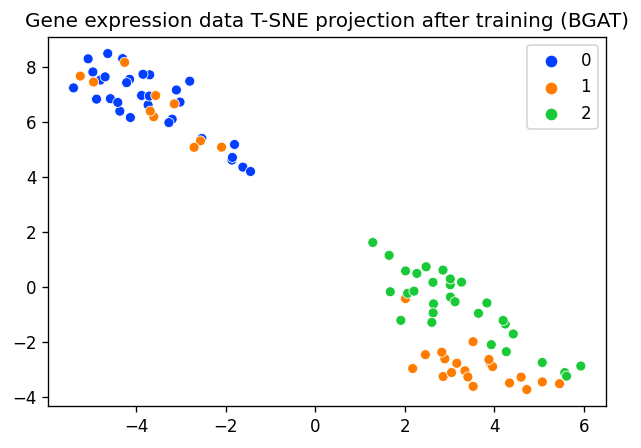

In [ ]:
model.eval()
out = model(Data["x"], Data["edge_index"])
visualize(out)

# Confusion matrix.

In [ ]:
pred_t = out.argmax(dim=1)
pred_t

tensor([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 2, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
        2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
Data["y"]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

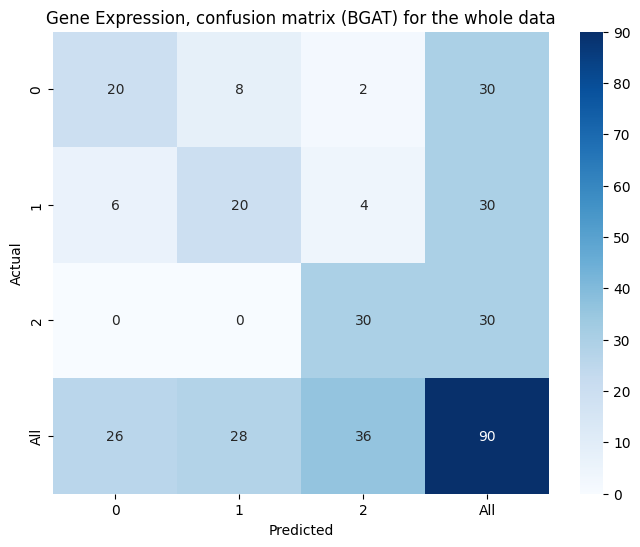

In [ ]:
import seaborn as sn
confusion_matrix = pd.crosstab(Data['y'], pred_t, rownames=['Actual'], colnames = ['Predicted'], margins = True)
plt.figure(figsize=(8, 6))
sn.heatmap(confusion_matrix, annot=True,  cmap="Blues", fmt='g')
plt.title('Gene Expression, confusion matrix (BGAT) for the whole data')
plt.show()

In [ ]:
pred = pred_t[Data["test_mask"]]

In [ ]:
act = Data["y"][Data["test_mask"]]

In [ ]:
data = {'y_Actual':    act,
        'y_Predicted':pred
        }

df = pd.DataFrame(data, columns = ['y_Actual','y_Predicted'])
df

,y_Actual,y_Predicted
0,0,0
1,0,0
2,1,1
3,1,0
4,2,2
5,2,2


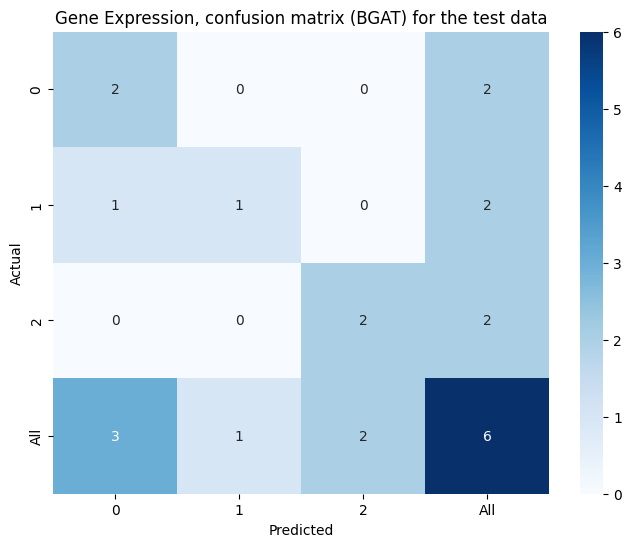

In [ ]:
import seaborn as sn
confusion_matrix = pd.crosstab(act, pred, rownames=['Actual'], colnames = ['Predicted'], margins = True)
plt.figure(figsize=(8, 6))
sn.heatmap(confusion_matrix, annot=True,  cmap="Blues", fmt='g')
plt.title('Gene Expression, confusion matrix (BGAT) for the test data')
plt.show()